In [35]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from holotomo.tomo import R
from holotomo.holo import G
from holotomo.magnification import M
from holotomo.shift import S

%matplotlib inline

cp.cuda.Device(0).use()
cp.random.seed(10)

# Init data sizes and parametes of the PXM of ID16A

In [36]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8 # make multiple of 8


## Read real and imaginary parts of the refractive index u = delta+i beta

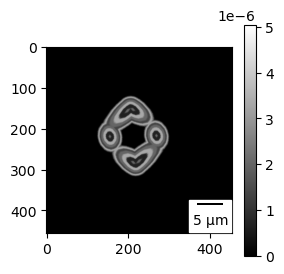

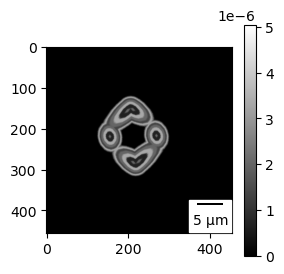

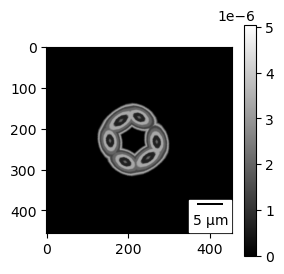

In [37]:
from cupyx.scipy import ndimage

cube_all = cp.zeros([ne,ne,ne],dtype='float32')
rr = (cp.ones(8)*408*0.2).astype(cp.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = [30, 28, 25, 21, 16,10,3]#, 6, 3,1]
for kk in range(len(amps)):
    cube = cp.zeros([ne,ne,ne],dtype='bool')
    r = rr[kk]
    p1 = ne//2-r//2
    p2 = ne//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = cp.meshgrid(cp.arange(-ne//2,ne//2),cp.arange(-ne//2,ne//2),cp.arange(-ne//2,ne//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(circ)))
    fcube = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(cube.astype('float32'))))
    cube = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=3)
cube_all[cube_all<0] = 0



u0 = (-1*cube_all*1e-6+1j*cube_all*1e-8)/1.5
u0=np.roll(u0,-15,axis=2)
u0=np.roll(u0,-10,axis=1)
v = cp.arange(-ne//2,ne//2)/ne
[vx,vy,vz] = cp.meshgrid(v,v,v)
v = cp.exp(-10*(vx**2+vy**2+vz**2))
fu = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(u0)))
u0 = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fu*v))).astype('complex64')

u = u0.astype('complex64').get()

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[ne//2].real.get(),cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[ne//2].real.get(),cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[:,ne//2-8].real.get(),cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()


u = cp.array(u0)


## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

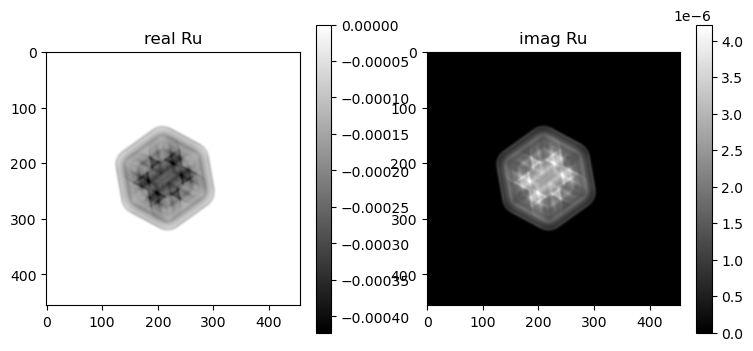

In [38]:
pars = {'theta': theta, 'rotation_axis': center*ne/n}
Ru = R(u,pars)*np.sqrt(ne*ntheta) # note, operator R is designed as scaled. 
# x = cp.linspace(-1,1,ne)
# x,y = cp.meshgrid(x,x)
# circ = x**2+y**2<0.5
# u = u*0+circ
# Ru = R(u,pars)*np.sqrt(ne*ntheta)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(cp.real(Ru[0]).get(),cmap='gray')
axs[0].set_title('real Ru')
fig.colorbar(im)
im=axs[1].imshow(cp.imag(Ru[0]).get(),cmap='gray')
axs[1].set_title('imag Ru')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [39]:
psi = cp.exp(2*cp.pi*1j/wavelength*voxelsize*Ru)

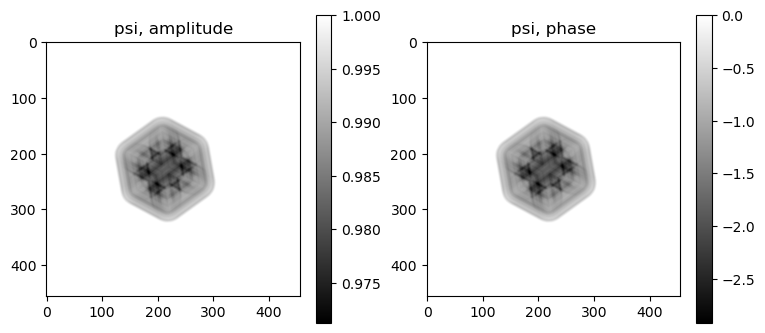

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
axs[0].set_title('psi, amplitude')
fig.colorbar(im)
im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
axs[1].set_title('psi, phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

In [41]:
prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_{2048}.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_{2048}.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  


for k in range(2):
    prb = prb[:,::2]+prb[:,1::2]
    prb = prb[:,:,::2]+prb[:,:,1::2]/4

prb = cp.array(prb[:,128-pad:-128+pad,128-pad:-128+pad])
prb/=cp.mean(cp.abs(prb))
# prb[:]=1

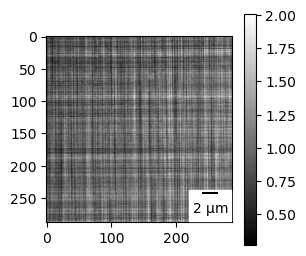

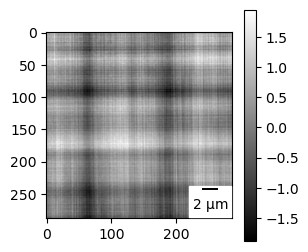

In [42]:
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(cp.abs(prb[0]).get(),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(cp.angle(prb[0]).get(),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()

prb0 = prb.copy()

# Smooth the probe, the loaded one is too noisy

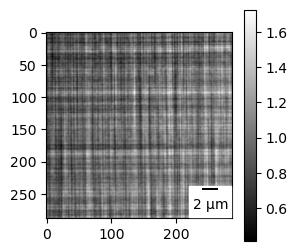

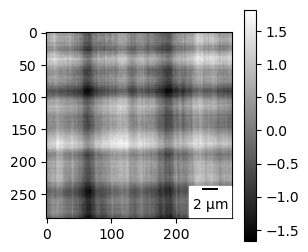

In [43]:
# v= cp.ones(n+2*pad,dtype='float32')
# vv = cp.sin(cp.linspace(0,1,n//8)*cp.pi/2)
# v[:n//8]=vv
# v[-n//8:]=vv[::-1]
# # plt.plot(v.get())
# v=cp.outer(v,v)


# # plt.imshow(v.get())
# prb=prb*v##+cp.mean(prb)*(1-v)

v = cp.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = cp.meshgrid(v,v)
v=cp.exp(-5*(vx**2+vy**2))
prb = cp.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb0)))
prb = cp.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(cp.abs(prb[0]).get(),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(cp.angle(prb[0]).get(),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()




# Random sample shifts (after magnification)

In [44]:
shifts_sample = (cp.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/32
shifts_ref = (cp.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/256# typically small

# Shifts of the probe (typically small)

In [45]:
shifts_ref0 = (cp.random.random([ndist,1,2]).astype('float32')-0.5)*n/256

# Compute holographic projections for all angles and all distances
### d = $\left|\mathcal{G}_{z_j}\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)\mathcal{M}_j\mathcal{S}_{s_{j}}\psi\right)\right|_2^2$

In [46]:
def fwd_holo(psi):
    ''' Holography data modeling operator '''

    data = cp.zeros([ndist, ntheta, n, n], dtype='complex64')
    for i in range(ndist):        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref[i]}        
        prbr = S(prb, pars)    
        # propagate illumination
        pars = {'wavelength': wavelength, 'z': distances2[i], 'voxelsize': voxelsize}
        prbr = G(prbr, pars)
        # object shift for each acquisition
        pars = {'shift': shifts_sample[i]/norm_magnifications[i]}        
        psir = S(psi, pars)      
        
        # scale object        
        if ne != n:
            pars = {'magnification': norm_magnifications[i]*ne/(n+2*pad), 'n': n+2*pad}
            psir = M(psir, pars)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        pars = {'wavelength': wavelength, 'z': distances[i], 'voxelsize': voxelsize}
        psir = G(psir, pars)   
        data[i] = psir[:,pad:n+pad,pad:n+pad]
    return data

def fwd_holo0(prb):
    ''' Holography data modeling operator without sample'''

    data = cp.zeros([ndist, n, n], dtype='complex64')
    for i in range(ndist):
        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref0[i]}        
        prbr = S(prb, pars)             
        
        # propagate illumination 
        pars = {'wavelength': wavelength, 'z': distances[0], 'voxelsize': voxelsize}
                 
        data[i] = G(prbr, pars)[:,pad:n+pad,pad:n+pad]
    return data

fpsi = fwd_holo(psi)
fref = fwd_holo0(prb)

## Take squared absolute value to simulate data on the detector and a reference image

In [47]:
data = cp.abs(fpsi)**2
ref = cp.abs(fref)**2

0.99124295


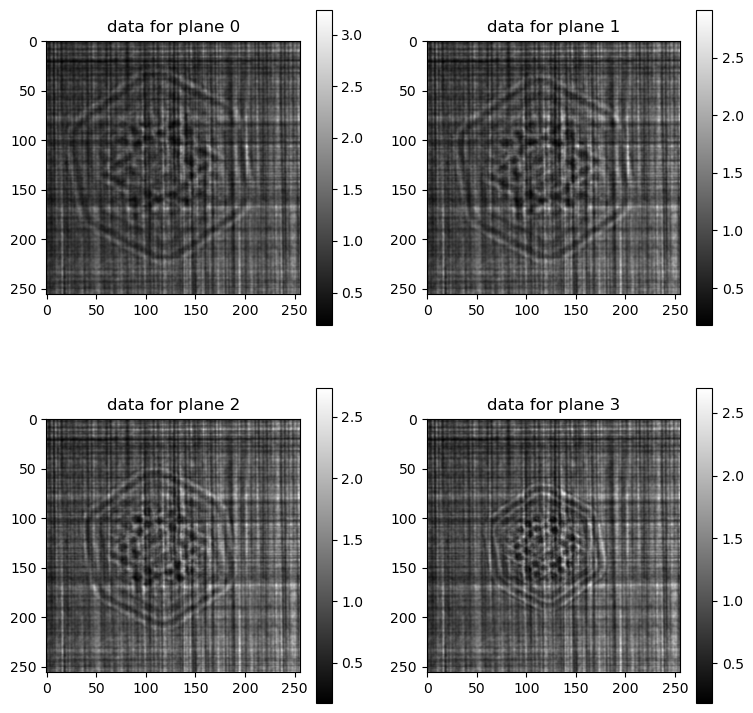

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0].get(),cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0].get(),cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0].get(),cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0].get(),cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)
print(cp.mean(cp.sqrt(data[0,0])))

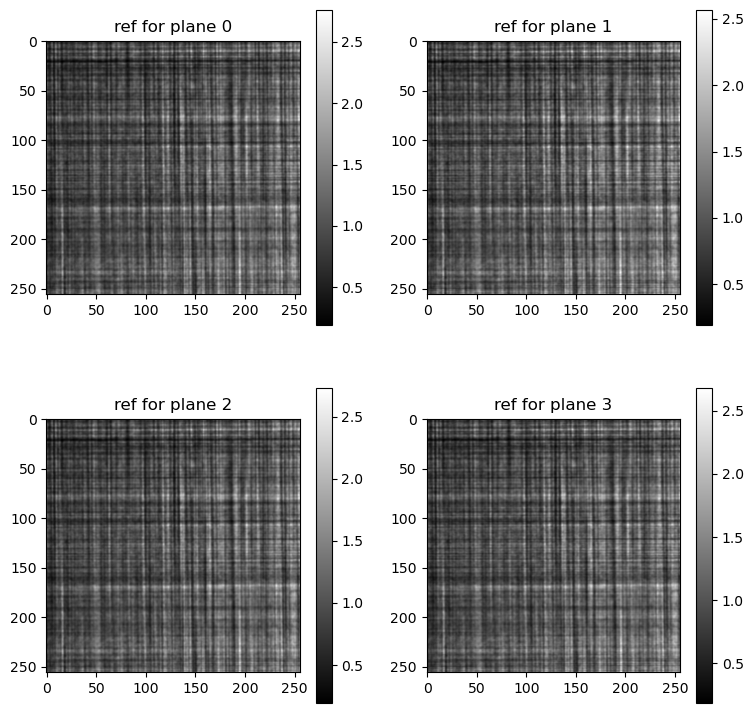

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref[0].get(),cmap='gray')
axs[0,0].set_title('ref for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref[1].get(),cmap='gray')
axs[0,1].set_title('ref for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(ref[2].get(),cmap='gray')
axs[1,0].set_title('ref for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(ref[3].get(),cmap='gray')
axs[1,1].set_title('ref for plane 3')
fig.colorbar(im)

# Save data, reference images, and shifts

In [50]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k].get(),f'/data/vnikitin/modeling/data_3d_ald_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[k].get(),f'/data/vnikitin/modeling/ref_3d_ald_{n}_{k}',overwrite=True)
np.save('/data/vnikitin/modeling/shifts_sample',shifts_sample.get())
np.save('/data/vnikitin/modeling/shifts_ref',shifts_ref.get())
np.save('/data/vnikitin/modeling/shifts_ref0',shifts_ref0.get())

In [51]:


# a = dxchange.read_tiff(f'/data/vnikitin/modeling/data_3d_ald_{n}_{0}_0.tiff')
# plt.imshow(a[3,]-data[3,0].get(),cmap='gray')
# plt.colorbar()

# plt.show()

# plt.imshow(a[3,32:-32,32:-32]-data[3,0,32:-32,32:-32].get(),cmap='gray')
# plt.colorbar()

# plt.show()